In [1]:
import matplotlib.pyplot as plt

In [51]:
import matplotlib as mpl
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib import ticker

plt.style.use('dark_background')

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10

mpl.rcParams['font.size'] = 30

mpl.rcParams['xtick.minor.size'] = 7
mpl.rcParams['ytick.minor.size'] = 7

mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3

mpl.rcParams['boxplot.boxprops.linewidth'] = 2.
mpl.rcParams['boxplot.medianprops.linewidth'] = 2.
mpl.rcParams['boxplot.flierprops.markersize'] = 12
mpl.rcParams['boxplot.whiskerprops.linewidth'] = 2.
mpl.rcParams['boxplot.capprops.linewidth'] = 2.


mpl.rcParams['axes.xmargin'] = mpl.rcParamsDefault['axes.xmargin']

In [52]:
from metacoadd.simu import run_metadetect, get_shear
import ngmix
import metadetect

In [53]:
def _get_exp_reconv_psf_size(psf):
        """
        taken from galsim/tests/test_metacal.py
        assumes the psf is centered
        """

        dk = psf.stepk/4.0
        print("dk:",dk)

        small_kval = 1.e-2    # Find the k where the given psf hits this kvalue
        smaller_kval = 3.e-3  # Target PSF will have this kvalue at the same k

        kim = psf.drawKImage(scale=dk)
        karr_r = kim.real.array
        # Find the smallest r where the kval < small_kval
        nk = karr_r.shape[0]
        kx, ky = np.meshgrid(np.arange(-nk/2, nk/2), np.arange(-nk/2, nk/2))
        ksq = (kx**2 + ky**2) * dk**2
        ksq_max = np.min(ksq[karr_r < small_kval * psf.flux])

        # We take our target PSF to be the (round) Gaussian that is even
        # smaller at this ksq
        # exp(-0.5 * ksq_max * sigma_sq) = smaller_kval
        sigma_sq = -2. * np.log(smaller_kval) / ksq_max

        return np.sqrt(sigma_sq)

In [54]:
import numpy as np
from descwl_shear_sims.sim import make_sim, get_se_dim  # for making a simulation realization
from descwl_shear_sims.psfs import make_fixed_psf, make_ps_psf
from descwl_shear_sims.galaxies import FixedGalaxyCatalog  # one of the galaxy catalog classes

seed = 8314
rng = np.random.RandomState(seed)

ntrial = 1
coadd_dim = 351
buff = 50
n_epoch = 7

for trial in range(ntrial):
    print('trial: %d/%d' % (trial+1, ntrial))

    # galaxy catalog; you can make your own
    galaxy_catalog = FixedGalaxyCatalog(
        rng=rng,
        coadd_dim=coadd_dim,
        buff=buff,
        layout='grid',
        mag=24,
        hlr=1.0,
    )

    # make a constant gaussian psf.  Any galsim object will do
    #psf = make_fixed_psf(psf_type='gauss')
    psf = []
    for i in range(n_epoch):
        fwhm_tmp = rng.normal(loc=0.8, scale=0.2)
        g1_psf = rng.normal()*0.01
        g2_psf = rng.normal()*0.01
        psf_tmp = make_fixed_psf(psf_type="gauss", fwhm=fwhm_tmp)
        psf_tmp = psf_tmp.shear(g1=g1_psf, g2=g2_psf)
        psf.append(psf_tmp)
        print(psf[i])
        print(g1_psf, g2_psf)
    #psf = make_ps_psf(rng=rng, dim=coadd_dim)

    # generate some simulation data, with a particular shear

    sim_data = make_sim(
        rng=rng,
        galaxy_catalog=galaxy_catalog,
        coadd_dim=coadd_dim,
        g1=0.02,
        g2=0.00,
        psf=psf,
        noise_factor=1e-5,
        do_coadd=True,
        #se_dim=int(coadd_dim*2),
        se_dim=coadd_dim,
        rotate=True,
        dither=True,
        epochs_per_band=n_epoch,
    )

    # the sim_data has keys
    #    band_data: a dict keyed by band with a list of single-epoch
    #      observations objects, one for each epoch.  The class is
    #      SEObs, defined in descwl_shear_sims.se_obs.py and has attributes
    #      for the image, weight map, wcs, noise image, bmask and a psf
    #      image generating method get_psf(x, y).  The images are galsim
    #      Image objects.
    #    coadd_wcs:  the wcs for the coadd
    #    psf_dims:  dimensions of the psf
    #    coadd_dims: dimensions of the coadd
    print('bands:', sim_data['band_data'].keys())
    print('nepocs i:', len(sim_data['band_data']['i']))
    print('image shape:', sim_data['band_data']['i'][0].image.array.shape)
    print('psf shape:', sim_data['psf_dims'])
    print('coadd shape:', sim_data['coadd_dims'])

trial: 1/1
galsim.Gaussian(sigma=0.3491384659619502).shear(galsim.Shear(g1=0.010444836474816697,g2=0.005853305944458693))
0.010444836474816746 0.005853305944458692
galsim.Gaussian(sigma=0.4878089405041096).shear(galsim.Shear(g1=0.010030846621421605,g2=-0.014562567196116585))
0.010030846621421617 -0.014562567196116583
galsim.Gaussian(sigma=0.2757465303050052).shear(galsim.Shear(g1=-0.00479776366000876,g2=-0.004046820996195018))
-0.004797763660008672 -0.004046820996195018
galsim.Gaussian(sigma=0.434130622163255).shear(galsim.Shear(g1=0.004638274158907244,g2=0.002810319998922561))
0.004638274158907303 0.002810319998922561
galsim.Gaussian(sigma=0.36976361923021706).shear(galsim.Shear(g1=0.016018512964131284,g2=-0.008677963109863076))
0.01601851296413128 -0.008677963109863076
galsim.Gaussian(sigma=0.36623560470384475).shear(galsim.Shear(g1=-0.014755979436845652,g2=-0.0059518724167420154))
-0.014755979436845715 -0.0059518724167420154
galsim.Gaussian(sigma=0.32955888032155983).shear(galsim.Sh

In [55]:
sim_data.keys()

dict_keys(['band_data', 'coadd_wcs', 'psf_dims', 'coadd_dims', 'bright_info', 'coadd_data'])

In [56]:
sim_data["coadd_dims"]

(351, 351)

In [57]:
def show_obs_mpl(obs):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(7,7))
    plt.imshow(obs.image.array, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.show()


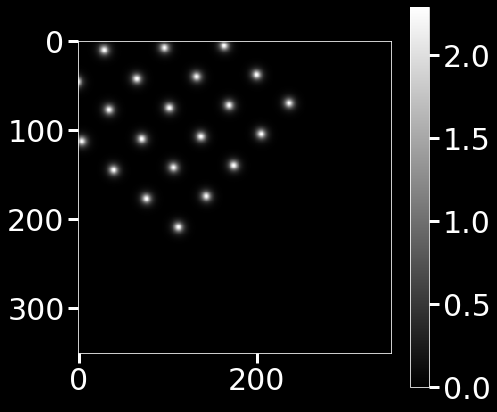

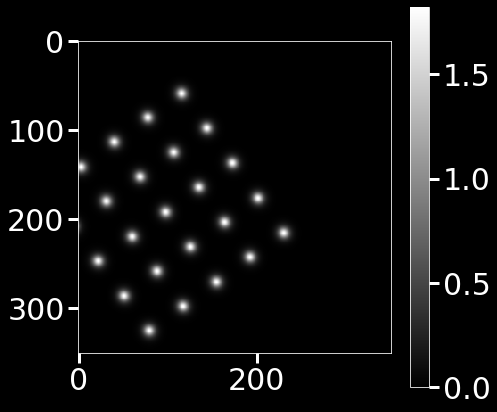

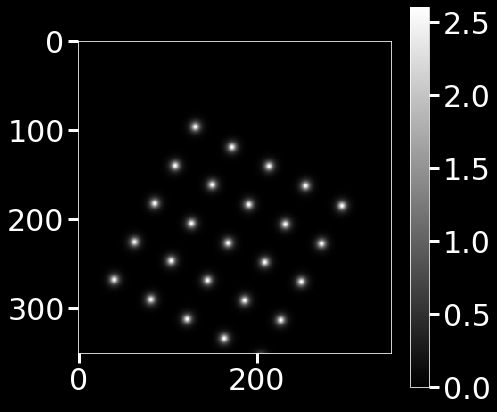

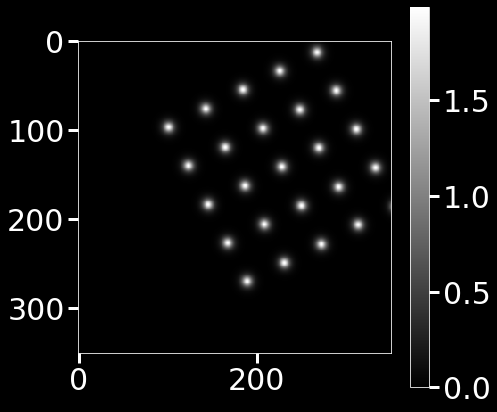

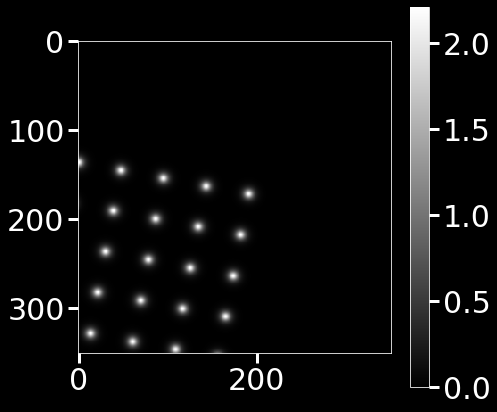

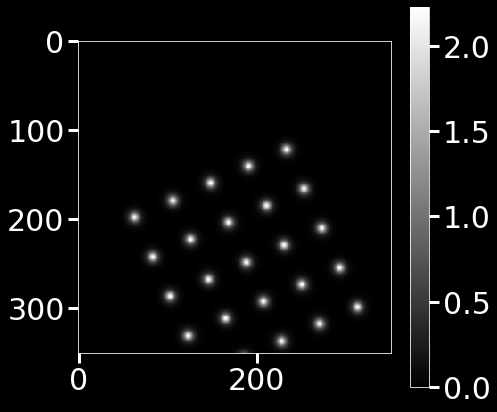

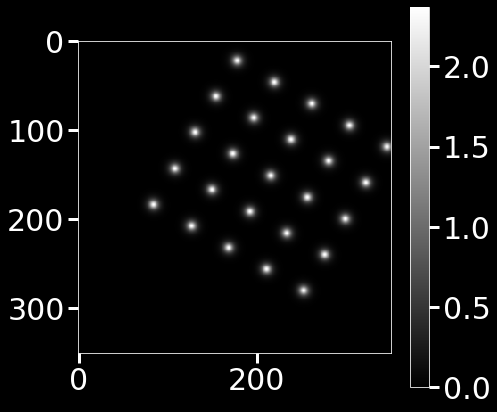

In [58]:
for i in range(n_epoch):
    show_obs_mpl(sim_data['band_data']['i'][i])

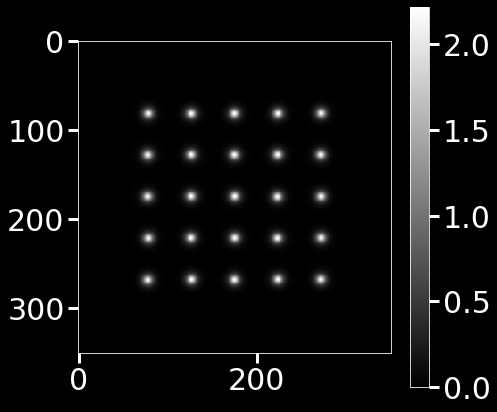

In [59]:
show_obs_mpl(sim_data['coadd_data'])

## Run MetaCoadd

In [60]:
from metacoadd.exposure import Exposure, ExpList, CoaddImage
from metacoadd.metacoadd import SimpleCoadd, MetaCoadd

In [61]:
import galsim
import copy

In [62]:
explist = ExpList()
rng=np.random.RandomState(1234)
safe_border = 50
for i in range(n_epoch):
    weight_img = 1/sim_data['band_data']['i'][i].variance.array
    weight_img[:safe_border,:] = 0
    weight_img[-safe_border:,:] = 0
    weight_img[:,:safe_border] = 0
    weight_img[:,-safe_border:] = 0
    exp = Exposure(
        image=sim_data['band_data']['i'][i].image.array,
        #weight=1/sim_data['band_data']['i'][i].variance.array,
        weight=weight_img,
        noise=rng.normal(size=sim_data['band_data']['i'][i].image.array.shape)*np.sqrt(sim_data["band_data"]["i"][i].variance.array),
        wcs=copy.deepcopy(sim_data['band_data']['i'][i].wcs),
    )
    explist.append(exp)

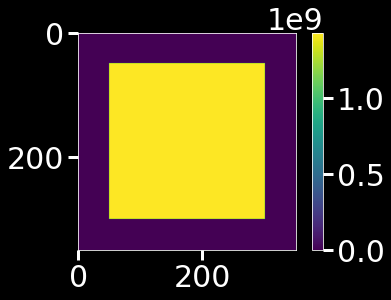

In [63]:
plt.imshow(weight_img)
plt.colorbar()

In [64]:
coaddimage = CoaddImage(
    explist,
    world_coadd_center=sim_data["coadd_wcs"].center,
    scale=np.abs(sim_data["coadd_wcs"].cd[0,0]*3600),
    image_coadd_size=sim_data["coadd_dims"][0],
    resize_exposure=True,
    relax_resize=0.31,
)
coaddimage.get_all_resamp_images()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 102.52538170406  76.502732043352  
PC1_1 PC1_2  : -4.1503826124377e-05  -3.6930369211853e-05  
PC2_1 PC2_2  : -3.6930369211853e-05  4.1503826124378e-05  
CDELT : 1.0  1.0  
NAXIS : 332  306
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 176.0  176.0  
CD1_1 CD1_2  : -5.5555555555555e-05  -0.0  
CD2_1 CD2_2  : 0.0  5.55555555555555e-05  
NAXIS : 351  351
image
galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=351, ymin=1, ymax=351), moments_status=0, observed_shape=galsim.Shear((0.017811708450152886+0.001266318993964805j)), moments_sigma=4.177419662475586, moments_amp=219.58370971679688, moments_centroid=galsim.PositionD(x=176.3451786302828, y=175.69272346020543), moments_rho4=2.2157607107844988, moments_n_iter=19, correction_status=-10)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CR

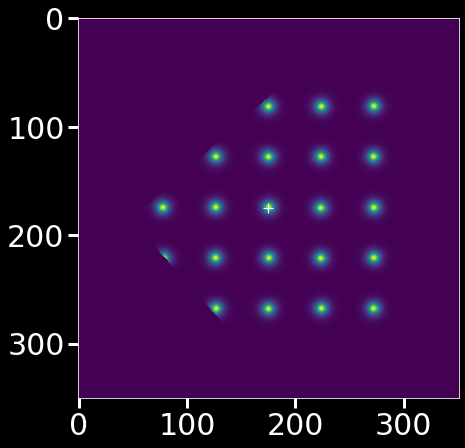

In [65]:
plt.figure(figsize=(7,7))
plt.imshow(coaddimage.explist[0].image_resamp.array)
plt.plot(175,175, 'w+')

#### Deal with the PSF

In [66]:
explist_psf = ExpList()
for i in range(n_epoch):
    coadd_center_on_exp = sim_data['band_data']['i'][i].wcs.toImage(
            sim_data["coadd_wcs"].center
        )
    gs_img = sim_data['band_data']['i'][i].psf._get_gspsf(coadd_center_on_exp)
    print(coadd_center_on_exp)
    print(coadd_center_on_exp.round())
    psf_img_local = gs_img.drawImage(
        center=coadd_center_on_exp,
        nx=sim_data["psf_dims"][0],
        ny=sim_data["psf_dims"][1],
        wcs=copy.deepcopy(sim_data['band_data']['i'][i].wcs),
    )
    #psf_img_local.shift(galsim.PositionI(1,1))
    psf_weight = np.ones_like(psf_img_local.array) / 1e-5**2
    psf_weight_galsim = galsim.Image(
            psf_weight,
            bounds=psf_img_local.bounds,
        )
    exp_psf = Exposure(
        image=psf_img_local,
        weight=psf_weight_galsim,
        wcs=copy.deepcopy(sim_data['band_data']['i'][i].wcs),
        #wcs=psf_img_local.wcs,
    )
    explist_psf.append(exp_psf)

galsim.PositionD(102.52538170405705,76.50273204335225)
galsim.PositionI(103,77)
galsim.PositionD(98.46033198627329,193.25021509928882)
galsim.PositionI(98,193)
galsim.PositionD(168.78775332257936,227.63280317500218)
galsim.PositionI(169,228)
galsim.PositionD(229.54936825220395,142.65258012446412)
galsim.PositionI(230,143)
galsim.PositionD(79.11510470657694,247.03301509470558)
galsim.PositionI(79,247)
galsim.PositionD(188.93622761783706,249.56153778216975)
galsim.PositionI(189,250)
galsim.PositionD(216.129268349293,152.48886458022994)
galsim.PositionI(216,152)


In [67]:
coaddimage_psf = CoaddImage(
    explist_psf,
    world_coadd_center=sim_data["coadd_wcs"].center,
    scale=np.abs(sim_data["coadd_wcs"].cd[0,0]*3600),
    image_coadd_size=sim_data["psf_dims"][0],
    resize_exposure=False,
    relax_resize=0.31,
)
coaddimage_psf.get_all_resamp_images()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 25.525381704057  25.502732043352  
PC1_1 PC1_2  : -4.1503826124377e-05  -3.6930369211853e-05  
PC2_1 PC2_2  : -3.6930369211853e-05  4.1503826124378e-05  
CDELT : 1.0  1.0  
NAXIS : 51  51
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 26.0  26.0  
CD1_1 CD1_2  : -5.5555555555555e-05  -0.0  
CD2_1 CD2_2  : 0.0  5.55555555555555e-05  
NAXIS : 51  51
image
galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=51, ymin=1, ymax=51), moments_status=0, observed_shape=galsim.Shear((0.010164302982201253+0.005694310013718058j)), moments_sigma=1.7696455717086792, moments_amp=1.000073790550232, moments_centroid=galsim.PositionD(x=25.999999812056142, y=26.000000334071903), moments_rho4=1.999820749795505, moments_n_iter=13, correction_status=-10)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 25

In [68]:
psf_noise = galsim.Image(np.random.normal(size=(51,51))*1e-5, wcs=coaddimage_psf.explist[0].image_resamp.wcs)

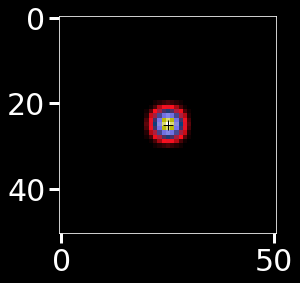

In [69]:
cen = 26
plt.imshow(coaddimage_psf.explist[0].image_resamp.array, cmap='gist_stern')
plt.plot(cen-1,cen-1, 'k+')

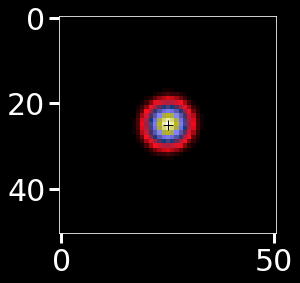

In [70]:
plt.imshow(coaddimage_psf.explist[1].image_resamp.array, cmap='gist_stern')
plt.plot(25,25, 'k+')

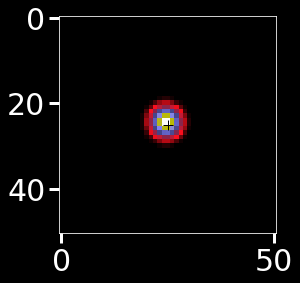

In [71]:
plt.imshow(coaddimage_psf.explist[0].image.array, cmap='gist_stern')
plt.plot(25,25, 'k+')

In [72]:
#plt.imshow(coaddimage_psf.image["noshear"].array, cmap='gist_stern')
#plt.plot(25,25, 'k+')

In [73]:
#_get_exp_reconv_psf_size(galsim.InterpolatedImage(perfect_psf_galsim, wcs=perfect_psf_galsim.wcs))

In [74]:
#plt.imshow(coaddimage_psf.explist[0].image_resamp.array-perfect_psf_galsim.array, cmap='gist_stern')
#plt.colorbar()

In [75]:
metacoadd = MetaCoadd(coaddimage, coaddimage_psf)

In [76]:
metacoadd.go()

0
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 102.52538170406  76.502732043352  
PC1_1 PC1_2  : -4.1503826124377e-05  -3.6930369211853e-05  
PC2_1 PC2_2  : -3.6930369211853e-05  4.1503826124378e-05  
CDELT : 1.0  1.0  
NAXIS : 332  306
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 176.0  176.0  
CD1_1 CD1_2  : -5.5555555555555e-05  -0.0  
CD2_1 CD2_2  : 0.0  5.55555555555555e-05  
NAXIS : 351  351
before
galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=51, ymin=1, ymax=51), moments_status=0, observed_shape=galsim.Shear((0.010164302982201253+0.005694310013718058j)), moments_sigma=1.7696455717086792, moments_amp=1.000073790550232, moments_centroid=galsim.PositionD(x=25.999999812056142, y=26.000000334071903), moments_rho4=1.999820749795505, moments_n_iter=13, correction_status=-10)
after
galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=51, ymin=1, ymax=51), m

In [77]:
perfect_rng = np.random.RandomState(1234)
perfect_psf_wcs = sim_data["coadd_data"].wcs.local(world_pos=sim_data["coadd_data"].wcs.center)
perfect_psf_galsim = sim_data["coadd_data"].psf.drawImage(
        nx=sim_data["psf_dims"][0],
        ny=sim_data["psf_dims"][1],
        wcs=perfect_psf_wcs,
    )
perfect_psf_obs = ngmix.Observation(
    image=perfect_psf_galsim.array,
    jacobian=ngmix.Jacobian(
        row=(sim_data["psf_dims"][0]-1)/2,
        col=(sim_data["psf_dims"][1]-1)/2,
        wcs=perfect_psf_wcs
    )
)
perfect_wcs = sim_data["coadd_data"].wcs.local(world_pos=sim_data["coadd_data"].wcs.center)
perfect_obs = ngmix.Observation(
    image=sim_data["coadd_data"].image.array,
    weight=np.ones_like(sim_data["coadd_data"].image.array)/sim_data["coadd_data"].variance.array,
    noise=rng.normal(size=sim_data["coadd_data"].image.array.shape)*np.sqrt(sim_data["coadd_data"].variance.array),
    jacobian=ngmix.Jacobian(
        row=(sim_data["coadd_dims"][0]-1)/2,
        col=(sim_data["coadd_dims"][1]-1)/2,
        wcs=perfect_wcs
    ),
    psf=perfect_psf_obs,
)
mcal_perfect = ngmix.metacal.get_all_metacal(
    perfect_obs,
    use_noise_image=True,
    psf=galsim.Gaussian(sigma=0.6, flux=1.)
)
#res = mdet.do_metadetect(
#        TEST_METADETECT_CONFIG,
#        mbobs,
#        np.random.RandomState(seed=seed),
#    )

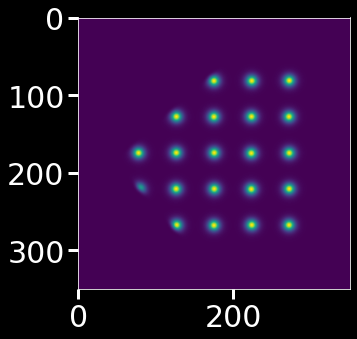

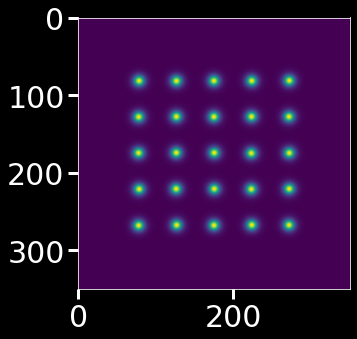

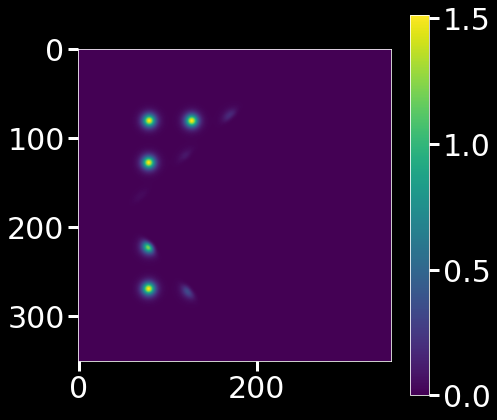

In [78]:
plt.figure(figsize=(5,5))
plt.imshow(metacoadd.stamps[0]['image']['noshear'].array)
plt.figure(figsize=(5,5))
plt.imshow(mcal_perfect["noshear"].image)
plt.figure(figsize=(7,7))
plt.imshow(mcal_perfect["1m"].image-metacoadd.stamps[0]['image']['1m'].array)
plt.colorbar()

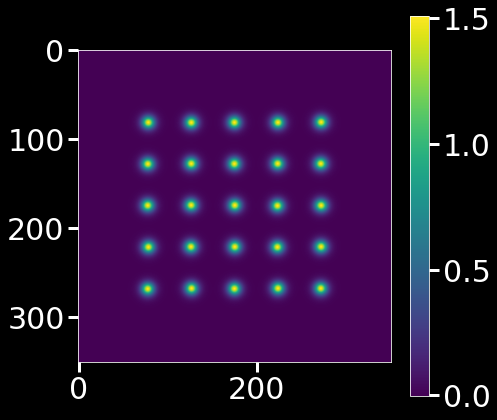

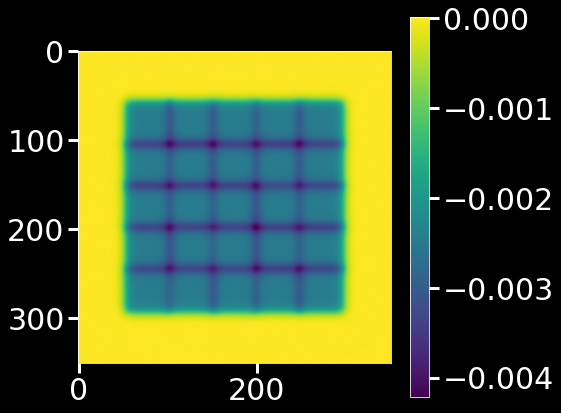

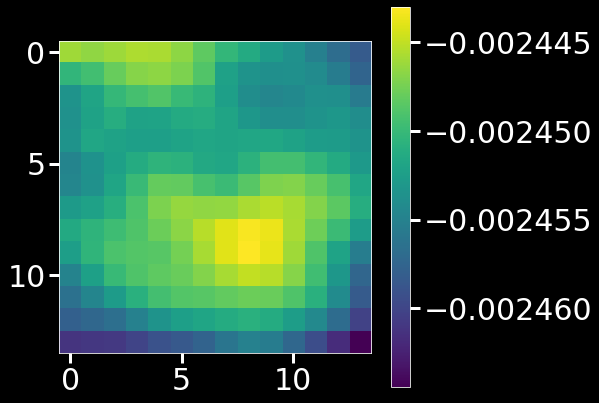

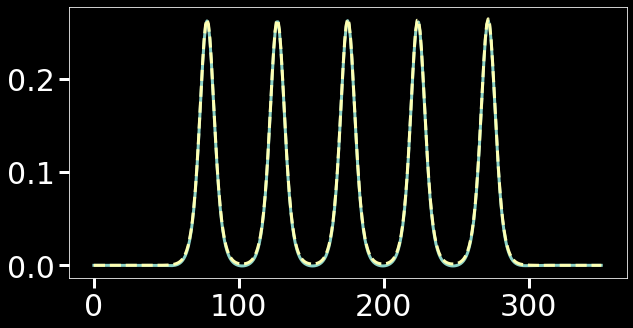

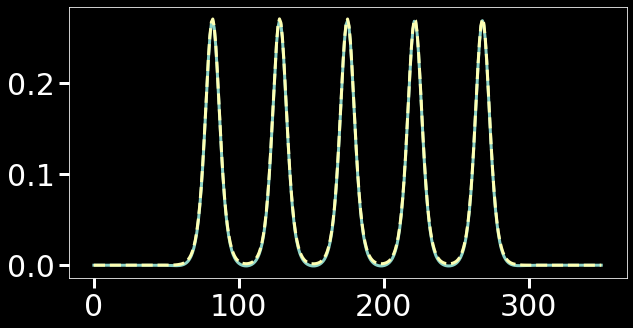

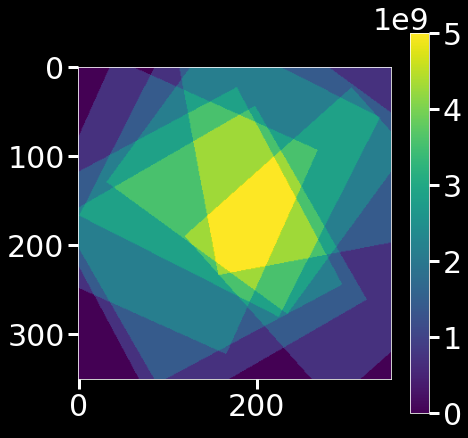

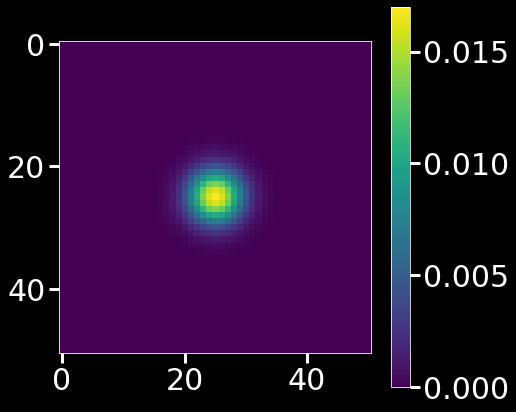

In [79]:
plt.figure(figsize=(7,7))
plt.imshow(metacoadd.coaddimage.image['noshear'].array)
plt.colorbar()
diff = metacoadd.coaddimage.image['noshear'].array-mcal_perfect["noshear"].image
plt.figure(figsize=(7,7))
plt.imshow(diff)
plt.colorbar()
plt.figure(figsize=(7,7))
plt.imshow(diff[75:89,72:86])
plt.colorbar()
plt.figure(figsize=(10,5))
plt.plot(np.mean(metacoadd.coaddimage.image['noshear'].array,0))
plt.plot(np.mean(mcal_perfect["noshear"].image,0), '--')
plt.figure(figsize=(10,5))
plt.plot(np.mean(metacoadd.coaddimage.image['noshear'].array,1))
plt.plot(np.mean(mcal_perfect["noshear"].image,1), '--')
plt.figure(figsize=(7,7))
plt.imshow(metacoadd.coaddimage.weight['noshear'].array)
plt.colorbar()
plt.figure(figsize=(7,7))
plt.imshow(metacoadd.psf_coaddimage.image['noshear'].array)
plt.colorbar()

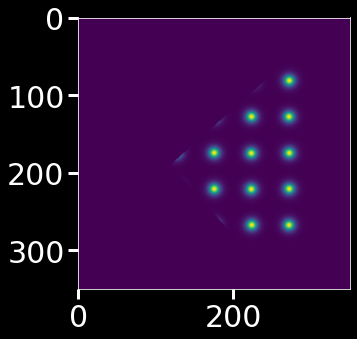

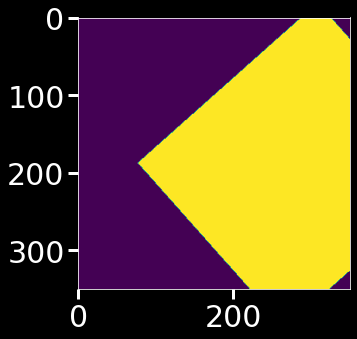

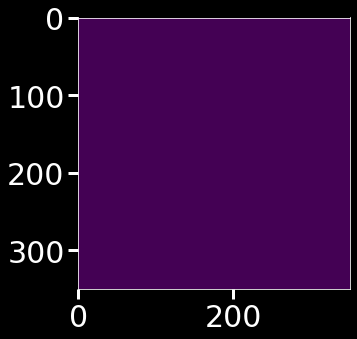

In [81]:
plt.figure(figsize=(5,5))
plt.imshow(metacoadd.stamps[0]["image"]["noshear"].array*metacoadd.stamps[0]["weight"]["noshear"].array)
plt.figure(figsize=(5,5))
plt.imshow(metacoadd.stamps[0]["border"].array)
plt.figure(figsize=(5,5))
plt.imshow((metacoadd.stamps[0]["image"]["noshear"]*metacoadd.stamps[0]["weight"]["noshear"].array*metacoadd.stamps[0]["border"]).array-metacoadd.stamps[0]["image"]["noshear"].array*metacoadd.stamps[0]["weight"]["noshear"].array)

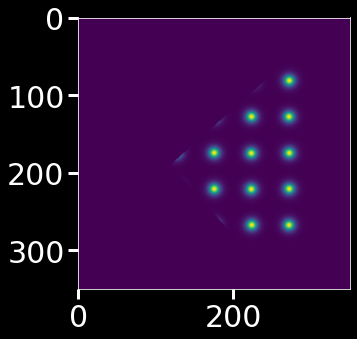

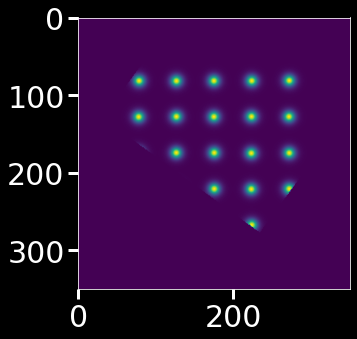

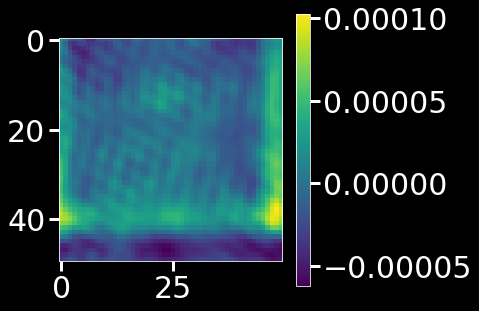

In [82]:
plt.figure(figsize=(5,5))
plt.imshow(metacoadd.stamps[0]["image"]["noshear"].array*metacoadd.stamps[0]["weight"]["noshear"].array)
plt.figure(figsize=(5,5))
plt.imshow(metacoadd.stamps[1]["image"]["noshear"].array*metacoadd.stamps[1]["weight"]["noshear"].array)
plt.figure(figsize=(5,5))
diff = metacoadd.stamps[0]["image"]["noshear"].array-metacoadd.stamps[1]["image"]["noshear"].array
plt.imshow(diff[250:300,200:250])
plt.colorbar()

In [83]:
diff[100:150,100:150]

array([[2.51795897e-03, 2.62869414e-03, 2.66246236e-03, ...,
        1.52866990e-03, 1.60473391e-03, 1.61578862e-03],
       [2.71402499e-03, 2.79195401e-03, 2.80545882e-03, ...,
        1.66796149e-03, 1.68807109e-03, 1.65463981e-03],
       [2.88930245e-03, 2.93920892e-03, 2.92794093e-03, ...,
        1.74904482e-03, 1.73386434e-03, 1.66805940e-03],
       ...,
       [1.69726574e-03, 1.58440142e-03, 1.43269513e-03, ...,
        9.84869817e-06, 1.09796551e-05, 9.70324197e-06],
       [1.68076609e-03, 1.56205656e-03, 1.40934422e-03, ...,
        2.49123227e-05, 4.96731752e-05, 5.60774676e-05],
       [1.63310668e-03, 1.51598747e-03, 1.36771878e-03, ...,
        3.06761968e-05, 6.78891860e-05, 9.72974486e-05]])

In [84]:
from metacoadd.simu.simu import _shear_cuts

In [85]:
res = metacoadd.results
res_shear = get_shear(res)
print(res_shear)

[(0.00438017, 3.12966679e-08, 0.21891835, 0.21902296)]


In [86]:
mask = _shear_cuts(res["noshear"], "wmom")

In [87]:
print("mean s2n:", np.mean(res["noshear"]["wmom_s2n"][mask]))

mean s2n: 595554.2898144241


(array([1., 0., 4., 0., 7., 1., 5., 1., 2., 4.]),
 array([395536.13317471, 429980.99332035, 464425.853466  , 498870.71361165,
        533315.5737573 , 567760.43390295, 602205.2940486 , 636650.15419425,
        671095.0143399 , 705539.87448555, 739984.7346312 ]),
 <BarContainer object of 10 artists>)

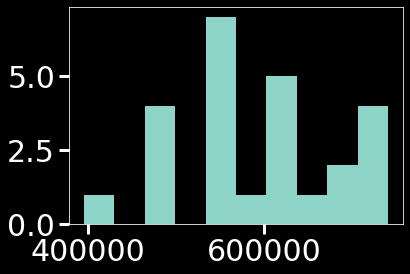

In [88]:
plt.hist(res["noshear"]["wmom_s2n"][mask])

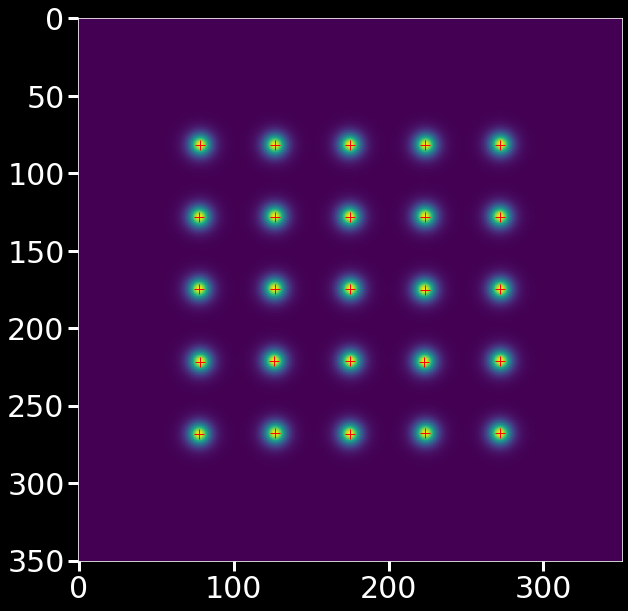

In [89]:
plt.figure(figsize=(10,10))
plt.imshow(metacoadd.coaddimage.image['noshear'].array)
plt.plot(res['noshear']["sx_col"][mask], res['noshear']["sx_row"][mask], 'r+')

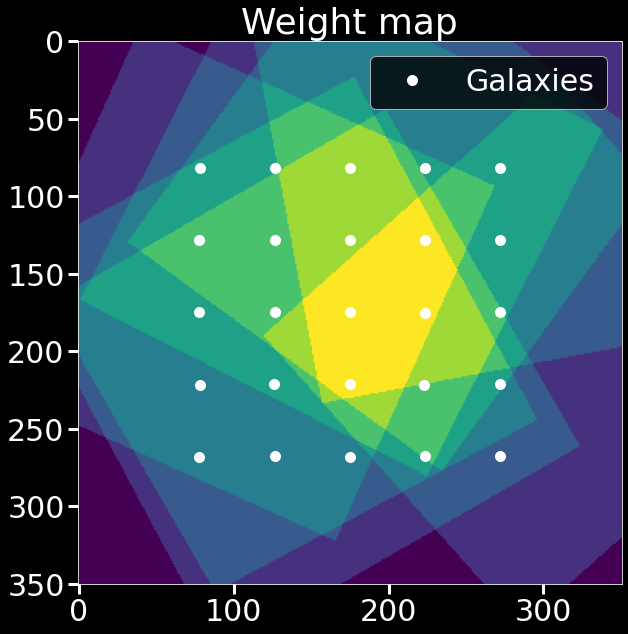

In [105]:
plt.figure(figsize=(10,10))
plt.imshow(metacoadd.coaddimage.weight['noshear'].array)
plt.plot(res['noshear']["sx_col"][mask], res['noshear']["sx_row"][mask], 'wo', label="Galaxies")
plt.legend()
plt.title("Weight map")
plt.savefig("/Users/aguinot/Documents/pipeline/metacoadd/notebooks/plots/weight_map.png")

In [90]:
from descwl_shear_sims.objlists import get_objlist
from descwl_shear_sims.surveys import get_survey

In [91]:
survey = get_survey(gal_type=galaxy_catalog.gal_type, band='i')
lists = get_objlist(
    galaxy_catalog=galaxy_catalog,
    survey=survey,
    star_catalog=None,
    noise=survey.noise*1e-5,
)
lists["objlist"][0]

galsim.Exponential(scale_radius=0.5958243473776976, flux=251.18864315095823, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05))

In [92]:
print("m (1e-3):", np.abs((0.02-res_shear['g1']/res_shear["R11"])/0.02)[0]/1e-3)
print("c (1e-5):", np.abs(res_shear['g2']/res_shear["R22"])[0]/1e-5)

m (1e-3): 0.41108474620327184
c (1e-5): 0.014289217624826742


In [42]:
np.mean(res["noshear"][mask]["wmom_band_flux"])

47.26120672799032

In [43]:
np.sqrt(np.var(res["noshear"][mask]["wmom_band_flux"]))

0.0001275506559043271

In [44]:
galsim.hsm.FindAdaptiveMom(galsim.Image(explist_psf[0].image.array))

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=51, ymin=1, ymax=51), moments_status=0, observed_shape=galsim.Shear((-0.004475316288766591+0.010757774989831001j)), moments_sigma=1.769598364830017, moments_amp=1.000054955482483, moments_centroid=galsim.PositionD(x=25.52538173836037, y=25.502732089896718), moments_rho4=1.9998899681970719, moments_n_iter=13, correction_status=-10)

In [45]:
galsim.hsm.FindAdaptiveMom(galsim.Image(metacoadd.psf_coaddimage.explist[0].image_resamp.array))

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=51, ymin=1, ymax=51), moments_status=0, observed_shape=galsim.Shear((0.010164302982201253+0.005694310013718058j)), moments_sigma=1.7696455717086792, moments_amp=1.000073790550232, moments_centroid=galsim.PositionD(x=25.999999812056142, y=26.000000334071903), moments_rho4=1.999820749795505, moments_n_iter=13, correction_status=-10)

In [46]:
galsim.hsm.FindAdaptiveMom(galsim.Image(coaddimage_psf.explist[0].image_resamp.array))

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=51, ymin=1, ymax=51), moments_status=0, observed_shape=galsim.Shear((0.010164302982201253+0.005694310013718058j)), moments_sigma=1.7696455717086792, moments_amp=1.000073790550232, moments_centroid=galsim.PositionD(x=25.999999812056142, y=26.000000334071903), moments_rho4=1.999820749795505, moments_n_iter=13, correction_status=-10)

In [47]:
galsim.hsm.FindAdaptiveMom(galsim.Image(metacoadd.psf_coaddimage.image['noshear'].array))

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=51, ymin=1, ymax=51), moments_status=0, observed_shape=galsim.Shear((-5.335444942296332e-07-2.4116054205868534e-05j)), moments_sigma=3.0600626468658447, moments_amp=1.0000114440917969, moments_centroid=galsim.PositionD(x=26.000051148619608, y=26.000040819007385), moments_rho4=1.9999971268328594, moments_n_iter=8, correction_status=-10)

In [48]:
galsim.hsm.FindAdaptiveMom(galsim.Image(perfect_psf_galsim.array))

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=51, ymin=1, ymax=51), moments_status=0, observed_shape=galsim.Shear((0.0012469686576156817-0.004283713692689339j)), moments_sigma=1.8109837770462036, moments_amp=0.9726139903068542, moments_centroid=galsim.PositionD(x=26.0, y=26.0), moments_rho4=2.051238429892367, moments_n_iter=17, correction_status=-10)

In [49]:
metacoadd.psf_coaddimage.image_coadd_center

galsim.PositionD(x=26.0, y=26.0)

In [50]:
simplecoadd.go()

NameError: name 'simplecoadd' is not defined

In [ ]:
show_obs_mpl(simplecoadd.coaddimage)

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(simplecoadd.coaddimage.weight.array, cmap='gray', interpolation='nearest')
plt.colorbar()

In [ ]:
plt.figure(figsize=(7,7))
max_true = np.max(sim_data['coadd_data'].image.array)
max_new = np.nanmax(simplecoadd.coaddimage.image.array)
plt.imshow(simplecoadd.coaddimage.image.array-sim_data['coadd_data'].image.array, cmap='gray')
plt.colorbar()
plt.title("SimpleCoadd")
print("max ori:", max_true)
print("max new:", max_new)
print("RMSE:", np.sqrt(np.nanmean((simplecoadd.coaddimage.image.array-sim_data['coadd_data'].image.array)**2)))

In [ ]:
plt.figure(figsize=(7,7))
diff = simplecoadd.coaddimage.image.array-sim_data['coadd_data'].image.array
plt.imshow(diff[0:100,0:100], cmap='gray', interpolation='nearest')
plt.colorbar()

In [ ]:
simplecoadd_psf = SimpleCoadd(coaddimage_psf, do_border=False)
simplecoadd_psf.go()

In [ ]:
show_obs_mpl(simplecoadd_psf.coaddimage)

In [ ]:
show_obs_mpl(simplecoadd.coaddimage)

In [ ]:
from metacoadd.simu import run_metadetect, get_shear

In [ ]:
from metacoadd.simu.simu import run_metadetect_perfect

In [ ]:
import metacoadd.simu.simu as sim

In [ ]:
res = run_metadetect(simplecoadd, simplecoadd_psf, 1234)
res_shear = get_shear(res)
print(res_shear)

In [ ]:
print("m (1e-3):", np.abs((0.02-res_shear['g1']/res_shear["R11"])/0.02)[0]/1e-3)
print("c (1e-4):", np.abs(res_shear['g2']/res_shear["R22"])[0]/1e-4)

In [ ]:
res_perfect = run_metadetect_perfect(sim_data["coadd_data"], 0.2, 1234)
res_shear_perfect = get_shear(res_perfect)
print(res_shear_perfect)

In [ ]:
print("m (1e-3):", np.abs((0.02-res_shear_perfect['g1']/res_shear_perfect["R11"])/0.02)[0]/1e-3)
print("c (1e-4):", np.abs(res_shear_perfect['g2']/res_shear_perfect["R22"])[0]/1e-4)

## Compare

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(sim_data['band_data']['i'][0].image.array-sim_data['coadd_data'].image.array, cmap='gray')
plt.colorbar()
plt.title("Input exp - true coadd")

In [ ]:
plt.figure(figsize=(7,7))
diff = sim_data['band_data']['i'][0].image.array-sim_data['coadd_data'].image.array
plt.imshow(diff[155:195,155:195], cmap='gray')
plt.colorbar()
plt.title("Input exp - true coadd")

In [ ]:
plt.figure(figsize=(7,7))
max_true = np.max(sim_data['coadd_data'].image.array)
max_new = np.max(simplecoadd.coaddimage.image.array)
plt.imshow(simplecoadd.coaddimage.image.array-sim_data['coadd_data'].image.array, cmap='gray')
plt.colorbar()
plt.title("SimpleCoadd")
print("max ori:", max_true)
print("max new:", max_new)

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(np.mean(simplecoadd.coaddimage.image.array, 0), label='simplecoadd')
plt.plot(np.mean(sim_data['coadd_data'].image.array, 0), label='True')
plt.legend()
plt.figure(figsize=(20, 7))
plt.plot(np.mean(simplecoadd.coaddimage.image.array, 1), label='simplecoadd')
plt.plot(np.mean(sim_data['coadd_data'].image.array, 1), label='True')
plt.legend()
plt.figure(figsize=(15, 7))
x = np.arange(50, 101)-50
plt.plot(x, np.mean(simplecoadd.coaddimage.image.array, 0)[50:101], label='simplecoadd')
plt.plot(np.mean(sim_data['coadd_data'].image.array, 0)[50:101], label='True')
plt.legend()
plt.figure(figsize=(15, 7))
x = np.arange(50, 101)-50
plt.plot(x, np.mean(simplecoadd.coaddimage.image.array, 1)[50:101], label='simplecoadd')
plt.plot(np.mean(sim_data['coadd_data'].image.array, 1)[50:101], label='True')
plt.legend()

In [ ]:
plt.figure(figsize=(7,7))
max_true = np.max(sim_data['band_data']['i'][0].image.array)
max_new = np.max(simplecoadd.coaddimage.image.array)
plt.imshow(simplecoadd.coaddimage.image.array-sim_data['band_data']['i'][0].image.array, cmap='gray')
plt.colorbar()
plt.title("SimpleCoadd")
print("max ori:", max_true)
print("max new:", max_new)

In [ ]:
def get_shape(image):
    gal_image = galsim.Image(image)
    s = galsim.hsm.FindAdaptiveMom(gal_image, strict=False)
    if s.error_message == '':
        print("g1:", s.observed_shape.g1, "g2:", s.observed_shape.g2)
    else:
        print("Error")
def get_shape_err(image, image_ref):
    gal_image = galsim.Image(image)
    s = galsim.hsm.FindAdaptiveMom(gal_image, strict=False)
    
    # Ref
    gal_image_ref = galsim.Image(image_ref)
    s_ref = galsim.hsm.FindAdaptiveMom(gal_image_ref, strict=False)
    if (s.error_message == '') and (s_ref.error_message == ''):
        print(
            "m (1e-3):", np.abs((s.observed_shape.g1-s_ref.observed_shape.g1)/s_ref.observed_shape.g1)/1e-3,
            "\nc (1e-4):", s.observed_shape.g2/1e-4,
        )
    else:
        print("Error")

In [ ]:
for i in range(n_epoch):
    get_shape(sim_data['band_data']['i'][i].image.array)

In [ ]:
get_shape(sim_data['coadd_data'].image.array)
get_shape_err(sim_data['coadd_data'].image.array, sim_data['band_data']['i'][0].image.array)

In [ ]:
get_shape(simplecoadd.coaddimage.image.array)

In [ ]:
get_shape_err(simplecoadd.coaddimage.image.array, sim_data['coadd_data'].image.array)